In [1]:
"""
MULTIPLE LINEAR REGRESSION (Enhanced + Polyniomial Feature + Log Transform + Auto Backward Elimination + Visualization)
Dataset: mg_house_data.csv
Author: MG (Mayank Gautam) , Data Scientist
==============================================================
Goal: Build a refined, interpretable regression model
that predicts house prices with 75%+ accuracy.
"""

'\nMULTIPLE LINEAR REGRESSION (Enhanced + Polyniomial Feature + Log Transform + Auto Backward Elimination + Visualization)\nDataset: mg_house_data.csv\nAuthor: MG (Mayank Gautam) , Data Scientist\n==============================================================\nGoal: Build a refined, interpretable regression model\nthat predicts house prices with 75%+ accuracy.\n'

In [2]:
# ---------------------- IMPORTING PACKAGES ----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm


In [3]:
sns.set_theme(style="whitegrid", context="talk")

In [4]:
dataset_path = "/kaggle/input/mg-house-data-usa/mg_house_data.csv"
df = pd.read_csv(dataset_path)

In [5]:
# View top 5 rows
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,04/13/14,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,04/13/15,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,04/13/16,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,04/13/17,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,04/13/18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
# ---------------------- DATA INSPECTION --------------------------
# Check for missing values
print("Missing Values:\n", df.isnull().any())

Missing Values:
 id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool


In [7]:
# Check data types (to identify categorical and numeric columns)
print("\nData Types:\n", df.dtypes)


Data Types:
 id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` 

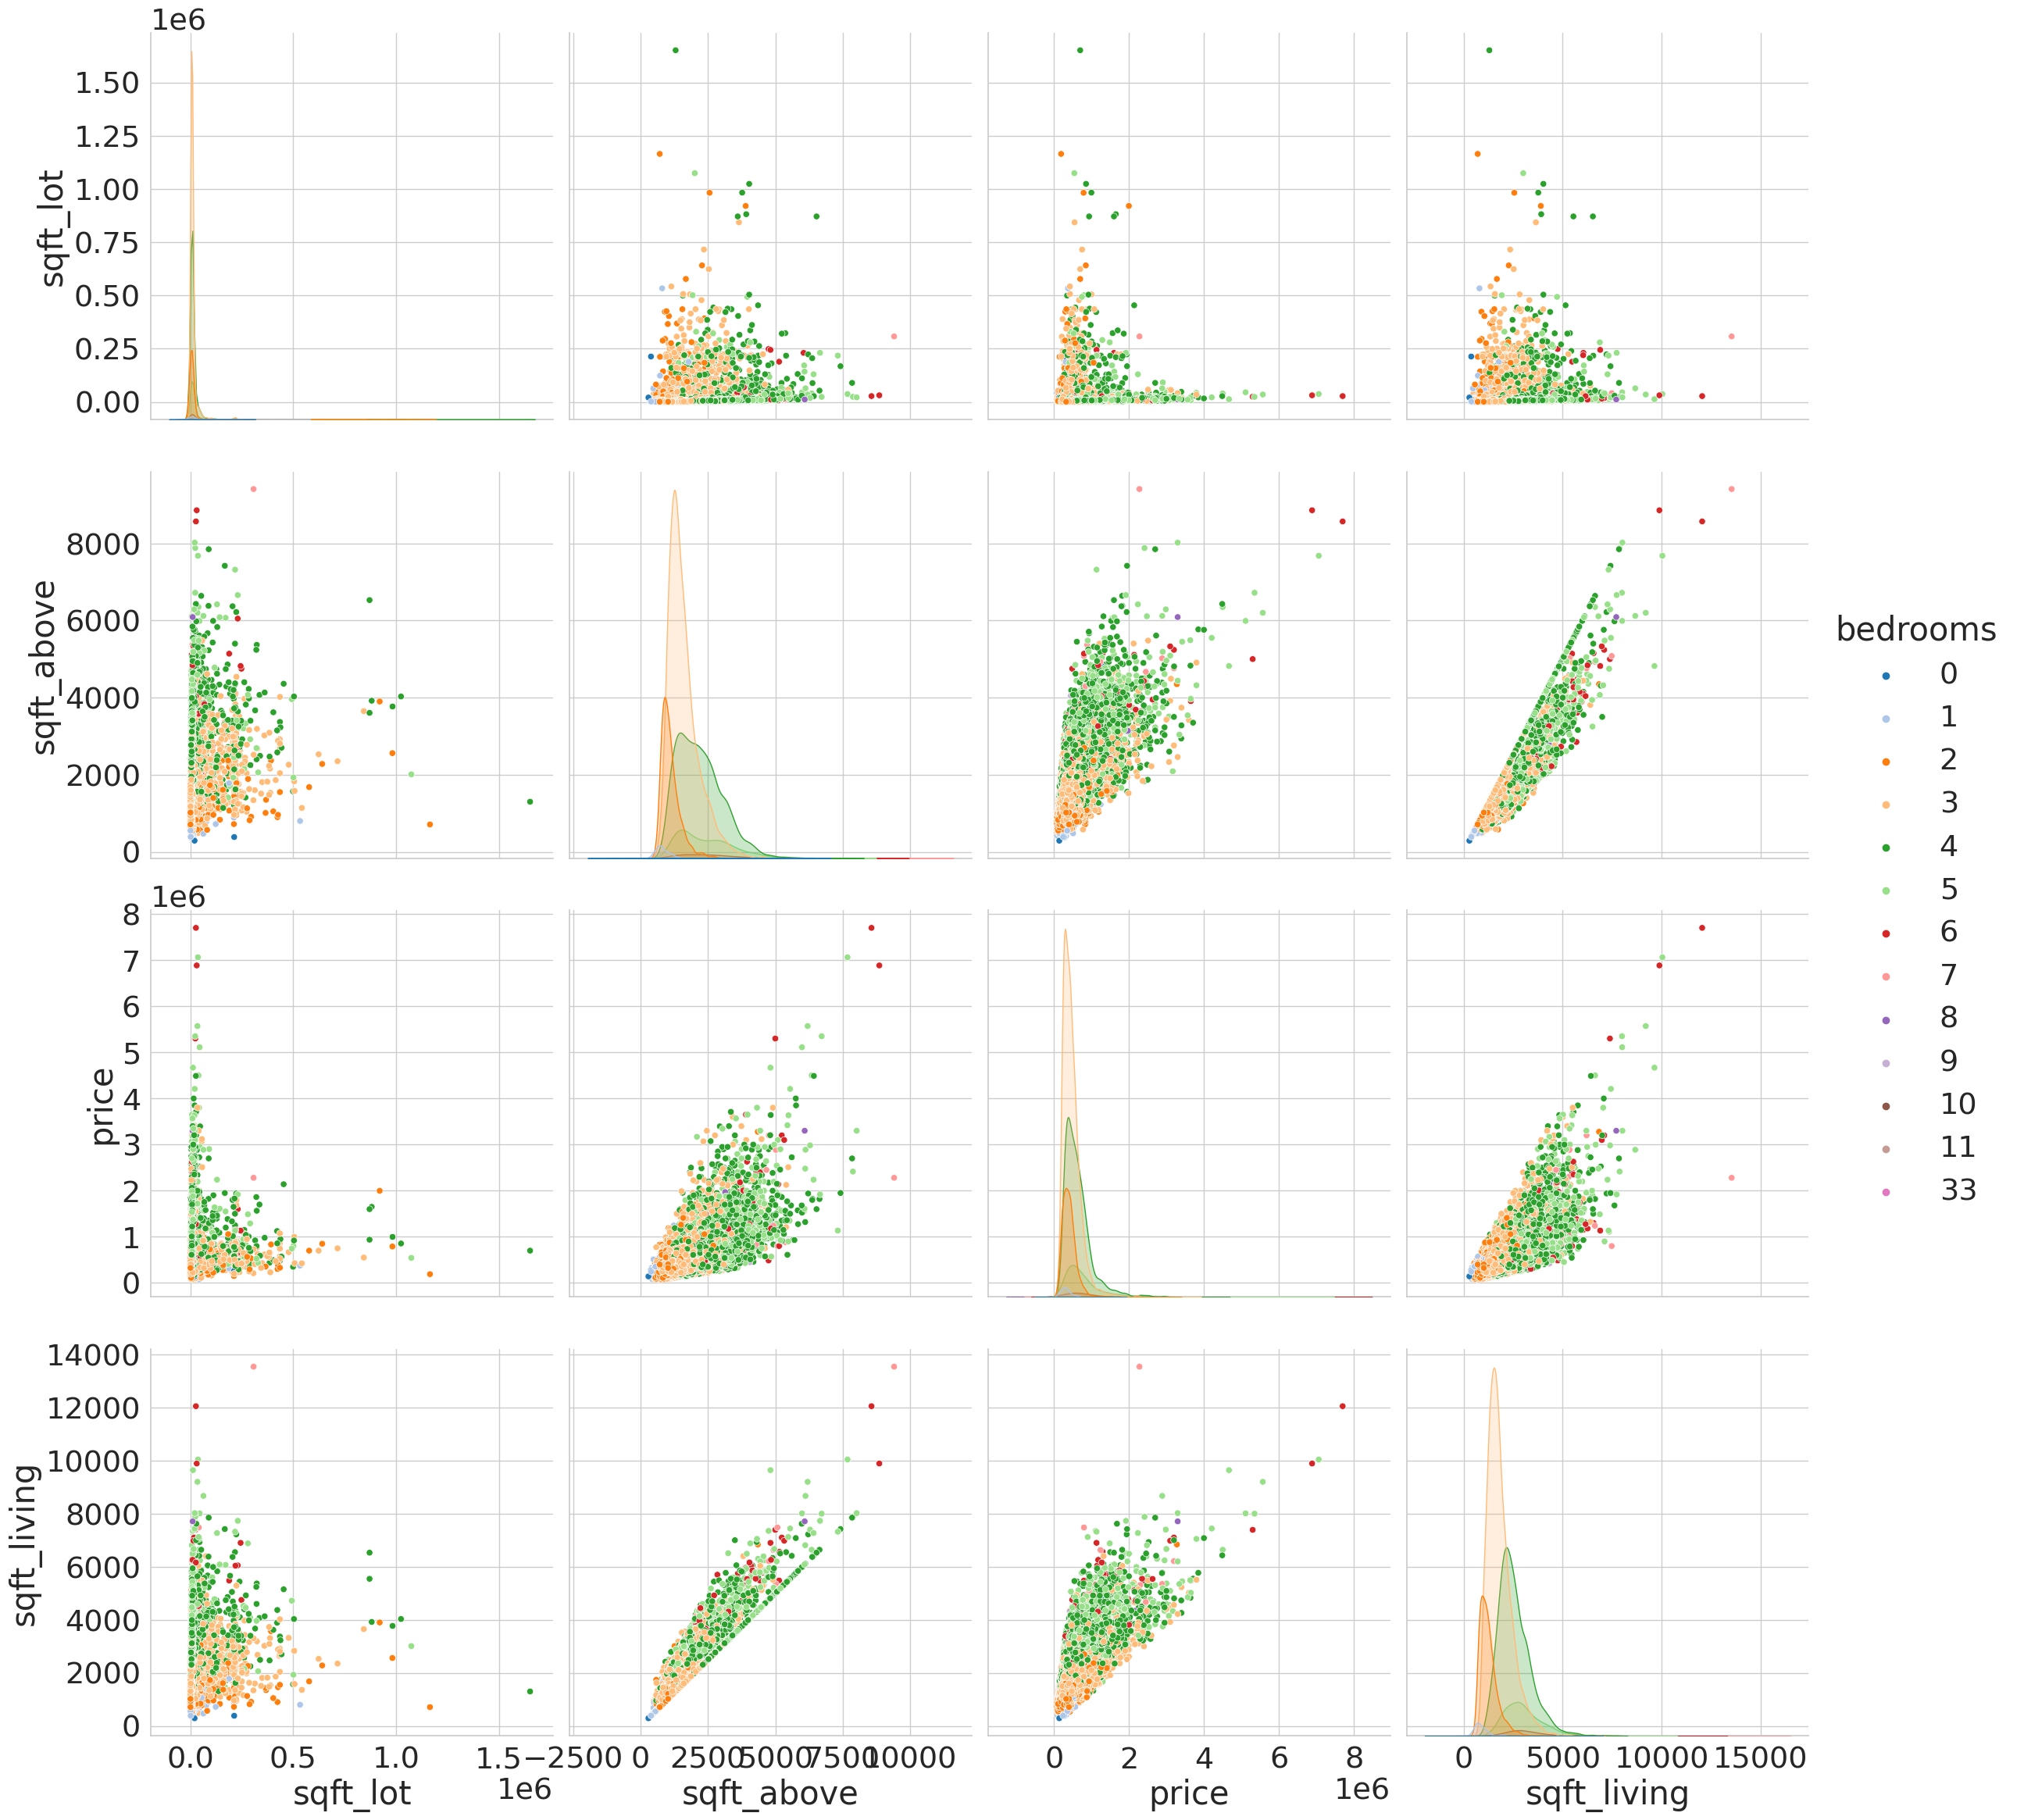

In [8]:
#understanding the distribution with seaborn
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
                 hue='bedrooms', palette='tab20',size=6)

In [9]:
# Quick glance at data
print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))

Dataset shape: (21613, 21)
Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [10]:
# ---------------------- STEP 2: FEATURE ENGINEERING ----------------------
df['house_age'] = 2025 - df['yr_built']  # current age of the property
df['time_since_renovated'] = df.apply(lambda row: 2025 - row['yr_renovated'] if row['yr_renovated'] > 0 else row['house_age'], axis=1)
df['total_sqft'] = df['sqft_living'] + df['sqft_basement']  # combined space
df['price_per_sqft'] = df['price'] / (df['sqft_living'] + 1)  # cost efficiency per living area


In [11]:
# Drop irrelevant features for now
df.drop(['id', 'date', 'yr_built', 'yr_renovated'], axis=1, inplace=True)

In [12]:
# ---------------------- STEP 3: OUTLIER HANDLING ----------------------
Q1, Q3 = df['price'].quantile([0.25, 0.75])
IQR = Q3 - Q1
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)].reset_index(drop=True)

In [13]:
# Insight: Removes luxury outliers skewing the regression line

In [14]:
# ---------------------- STEP 4: LOG TRANSFORM ----------------------
# Log-transforming to stabilize variance and normalize skewed data
for col in ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'total_sqft']:
    df[col] = np.log1p(df[col])


In [15]:

# ---------------------- STEP 5: FEATURE SELECTION ----------------------
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','house_age','time_since_renovated','total_sqft','lat','long']

In [16]:
# ----------------------STEP 6: DEFINING VARIABLES -----------------------
x = df[features]                                  # Independent features
y = df['price'].reset_index(drop=True)           # Dependent variable

In [17]:
# ---------------------- STEP 7 ----------------------
# Standardization ensures features are on the same scale
x = pd.get_dummies(x, drop_first=True, dtype=int)
scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns).reset_index(drop=True)

In [18]:
# ---------------------- STEP 8: POLYNOMIAL FEATURES ----------------------
# Capture nonlinear interactions between variables
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly.fit_transform(x_scaled)
x_poly_df = pd.DataFrame(x_poly, columns=poly.get_feature_names_out(x.columns)).reset_index(drop=True)

In [19]:
# ---------------------- STEP 9: TRAIN/TEST SPLIT ----------------------
x_train, x_test, y_train, y_test = train_test_split(x_poly_df, y, test_size=0.2, random_state=42)

In [20]:
# ---------------------- STEP 10: INITIAL MODEL TRAINING ----------------------
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [21]:
# ---------------------- STEP 11: BACKWARD ELIMINATION ----------------------
x_opt = sm.add_constant(x_poly_df).reset_index(drop=True)
y = y.reset_index(drop=True)

In [22]:
cols = list(x_opt.columns)
p_max = 1
elimination_progress = []

In [23]:
# Auto-drop variables with p values > 0.005
while len(cols) > 0 and p_max > 0.005:
    x_opt_selected = x_opt[cols]
    model_ols = sm.OLS(y, x_opt_selected).fit()
    p_values = model_ols.pvalues
    p_max = max(p_values)
    if p_max > 0.005:
        excluded_feature = p_values.idxmax()
        elimination_progress.append((excluded_feature, p_max))
        print(f"🧹 Dropping '{excluded_feature}' (p={p_max:.4f})")
        cols.remove(excluded_feature)
    else:
        break

🧹 Dropping 'waterfront sqft_above' (p=0.9975)
🧹 Dropping 'total_sqft lat' (p=0.9826)
🧹 Dropping 'condition time_since_renovated' (p=0.9794)
🧹 Dropping 'bedrooms view' (p=0.9794)
🧹 Dropping 'view condition' (p=0.9416)
🧹 Dropping 'bathrooms total_sqft' (p=0.9263)
🧹 Dropping 'floors sqft_above' (p=0.9265)
🧹 Dropping 'sqft_lot time_since_renovated' (p=0.9231)
🧹 Dropping 'bedrooms sqft_lot' (p=0.9025)
🧹 Dropping 'bedrooms sqft_basement' (p=0.8705)
🧹 Dropping 'bedrooms lat' (p=0.8654)
🧹 Dropping 'bedrooms house_age' (p=0.8054)
🧹 Dropping 'bathrooms sqft_lot' (p=0.7988)
🧹 Dropping 'bathrooms long' (p=0.7918)
🧹 Dropping 'floors condition' (p=0.7737)
🧹 Dropping 'bathrooms view' (p=0.7651)
🧹 Dropping 'sqft_lot long' (p=0.7238)
🧹 Dropping 'long' (p=0.6883)
🧹 Dropping 'sqft_lot sqft_above' (p=0.6599)
🧹 Dropping 'floors time_since_renovated' (p=0.5892)
🧹 Dropping 'sqft_lot sqft_basement' (p=0.5829)
🧹 Dropping 'sqft_lot total_sqft' (p=0.7478)
🧹 Dropping 'bedrooms bathrooms' (p=0.5837)
🧹 Dropping 'sq

In [24]:
# ---------------------- STEP 12: FINAL MODEL ----------------------
final_model = sm.OLS(y, x_opt[cols]).fit()
print("\nAFTER BACKWARD ELIMINATION:")
print(final_model.summary())


AFTER BACKWARD ELIMINATION:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     1116.
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:09:41   Log-Likelihood:                 2237.0
No. Observations:               20467   AIC:                            -4354.
Df Residuals:                   20407   BIC:                            -3878.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [25]:
# ---------------------- STEP 13: MODEL EVALUATION ----------------------
x_reduced = x_opt[cols].drop('const', axis=1)
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_reduced, y, test_size=0.2, random_state=42)

In [26]:
model_final = LinearRegression()
model_final.fit(x_train_r, y_train_r)
y_pred_final = model_final.predict(x_test_r)

In [27]:
r2_final = r2_score(y_test_r, y_pred_final)
mae = mean_absolute_error(np.expm1(y_test_r), np.expm1(y_pred_final))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test_r), np.expm1(y_pred_final)))
accuracy = r2_final * 100

In [28]:
# ASSINGING VARIABLES
print(f"\nOptimized R² Score: {accuracy}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Optimized R² Score: 75.33145308791539%
MAE: 75763.91
RMSE: 105465.04


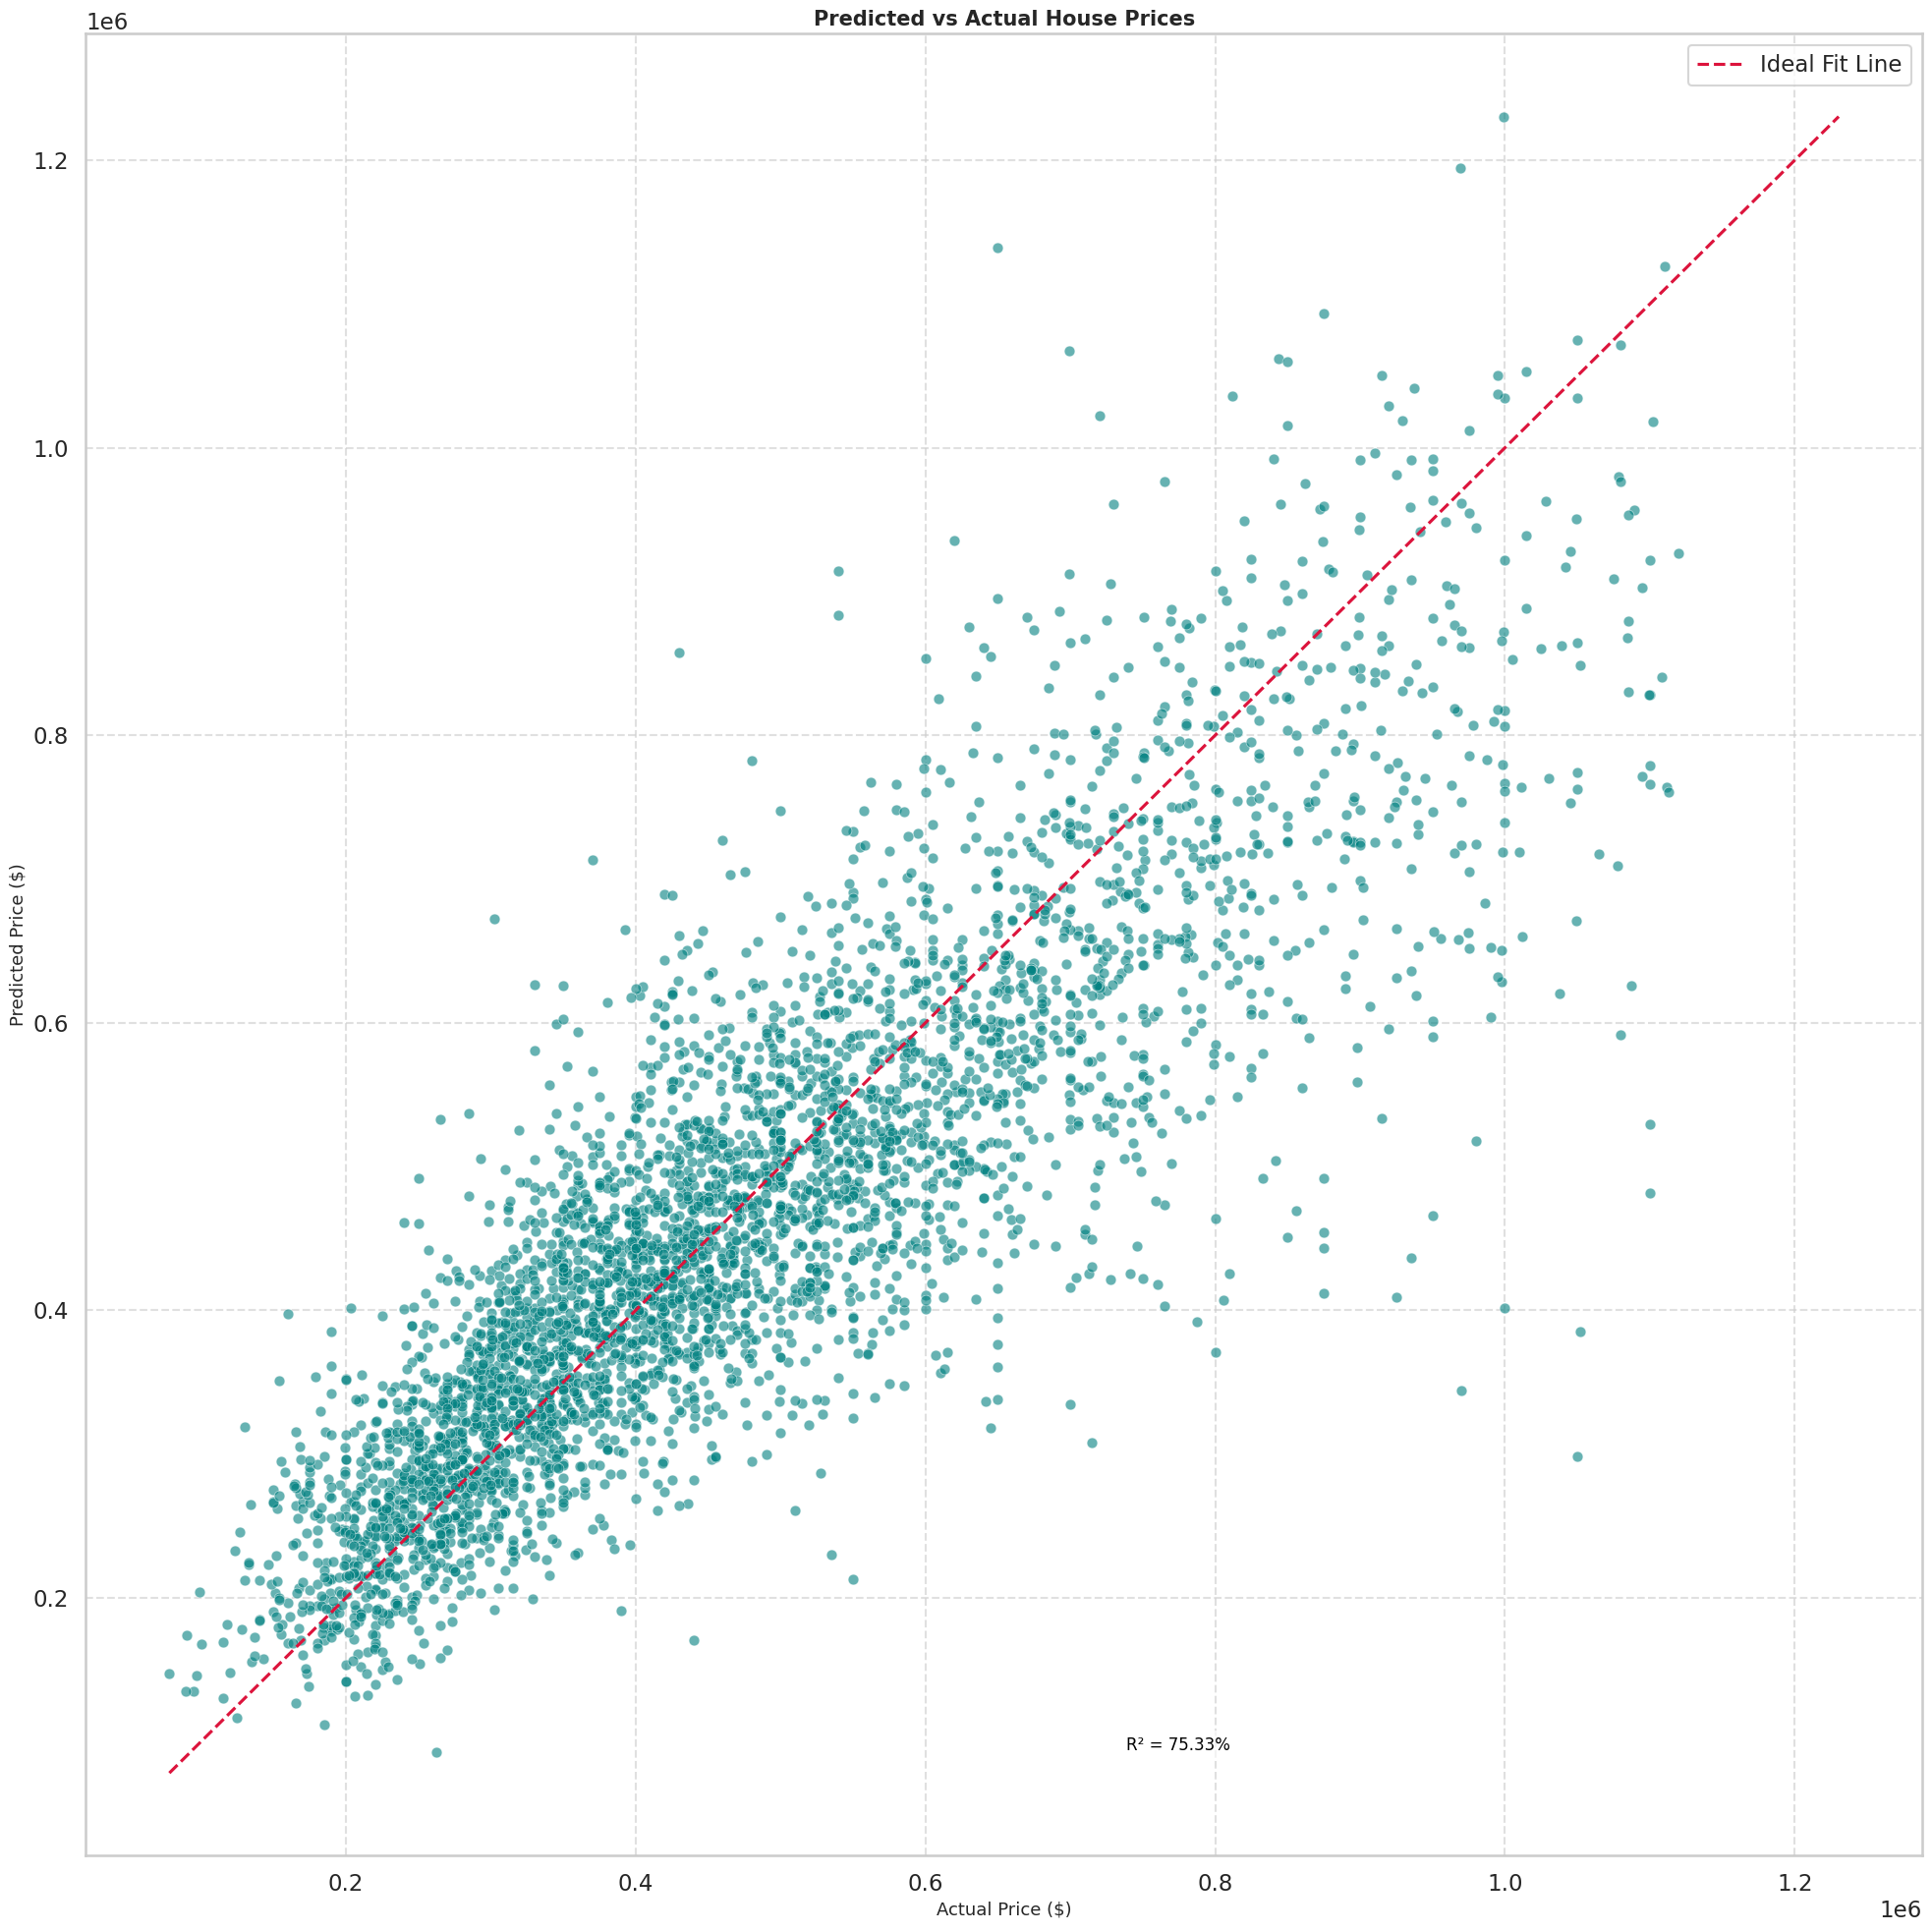

In [29]:
# ---------------------- STEP 12: VISUALIZATION ----------------------
plt.figure(figsize=(20, 20))

# Predicted vs Actual Prices (Converted from Log to Numeric)
actual_prices = np.expm1(y_test_r)
predicted_prices = np.expm1(y_pred_final)

sns.scatterplot(x=actual_prices, y=predicted_prices, alpha=0.6, color='teal', s=60, edgecolor='white', linewidth=0.5)
plt.xlabel("Actual Price ($)", fontsize=13)
plt.ylabel("Predicted Price ($)", fontsize=13)
plt.title("Predicted vs Actual House Prices", fontsize=15, fontweight='bold')

# Perfect correlation line
min_price = min(actual_prices.min(), predicted_prices.min())
max_price = max(actual_prices.max(), predicted_prices.max())
plt.plot([min_price, max_price], [min_price, max_price], color='crimson', linestyle='--', label='Ideal Fit Line')

# Annotate with correlation label
r2_text = f"R² = {r2_final * 100:.2f}%"
plt.text(max_price * 0.6, min_price * 1.2, r2_text, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.6))

# Add grid and legend
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


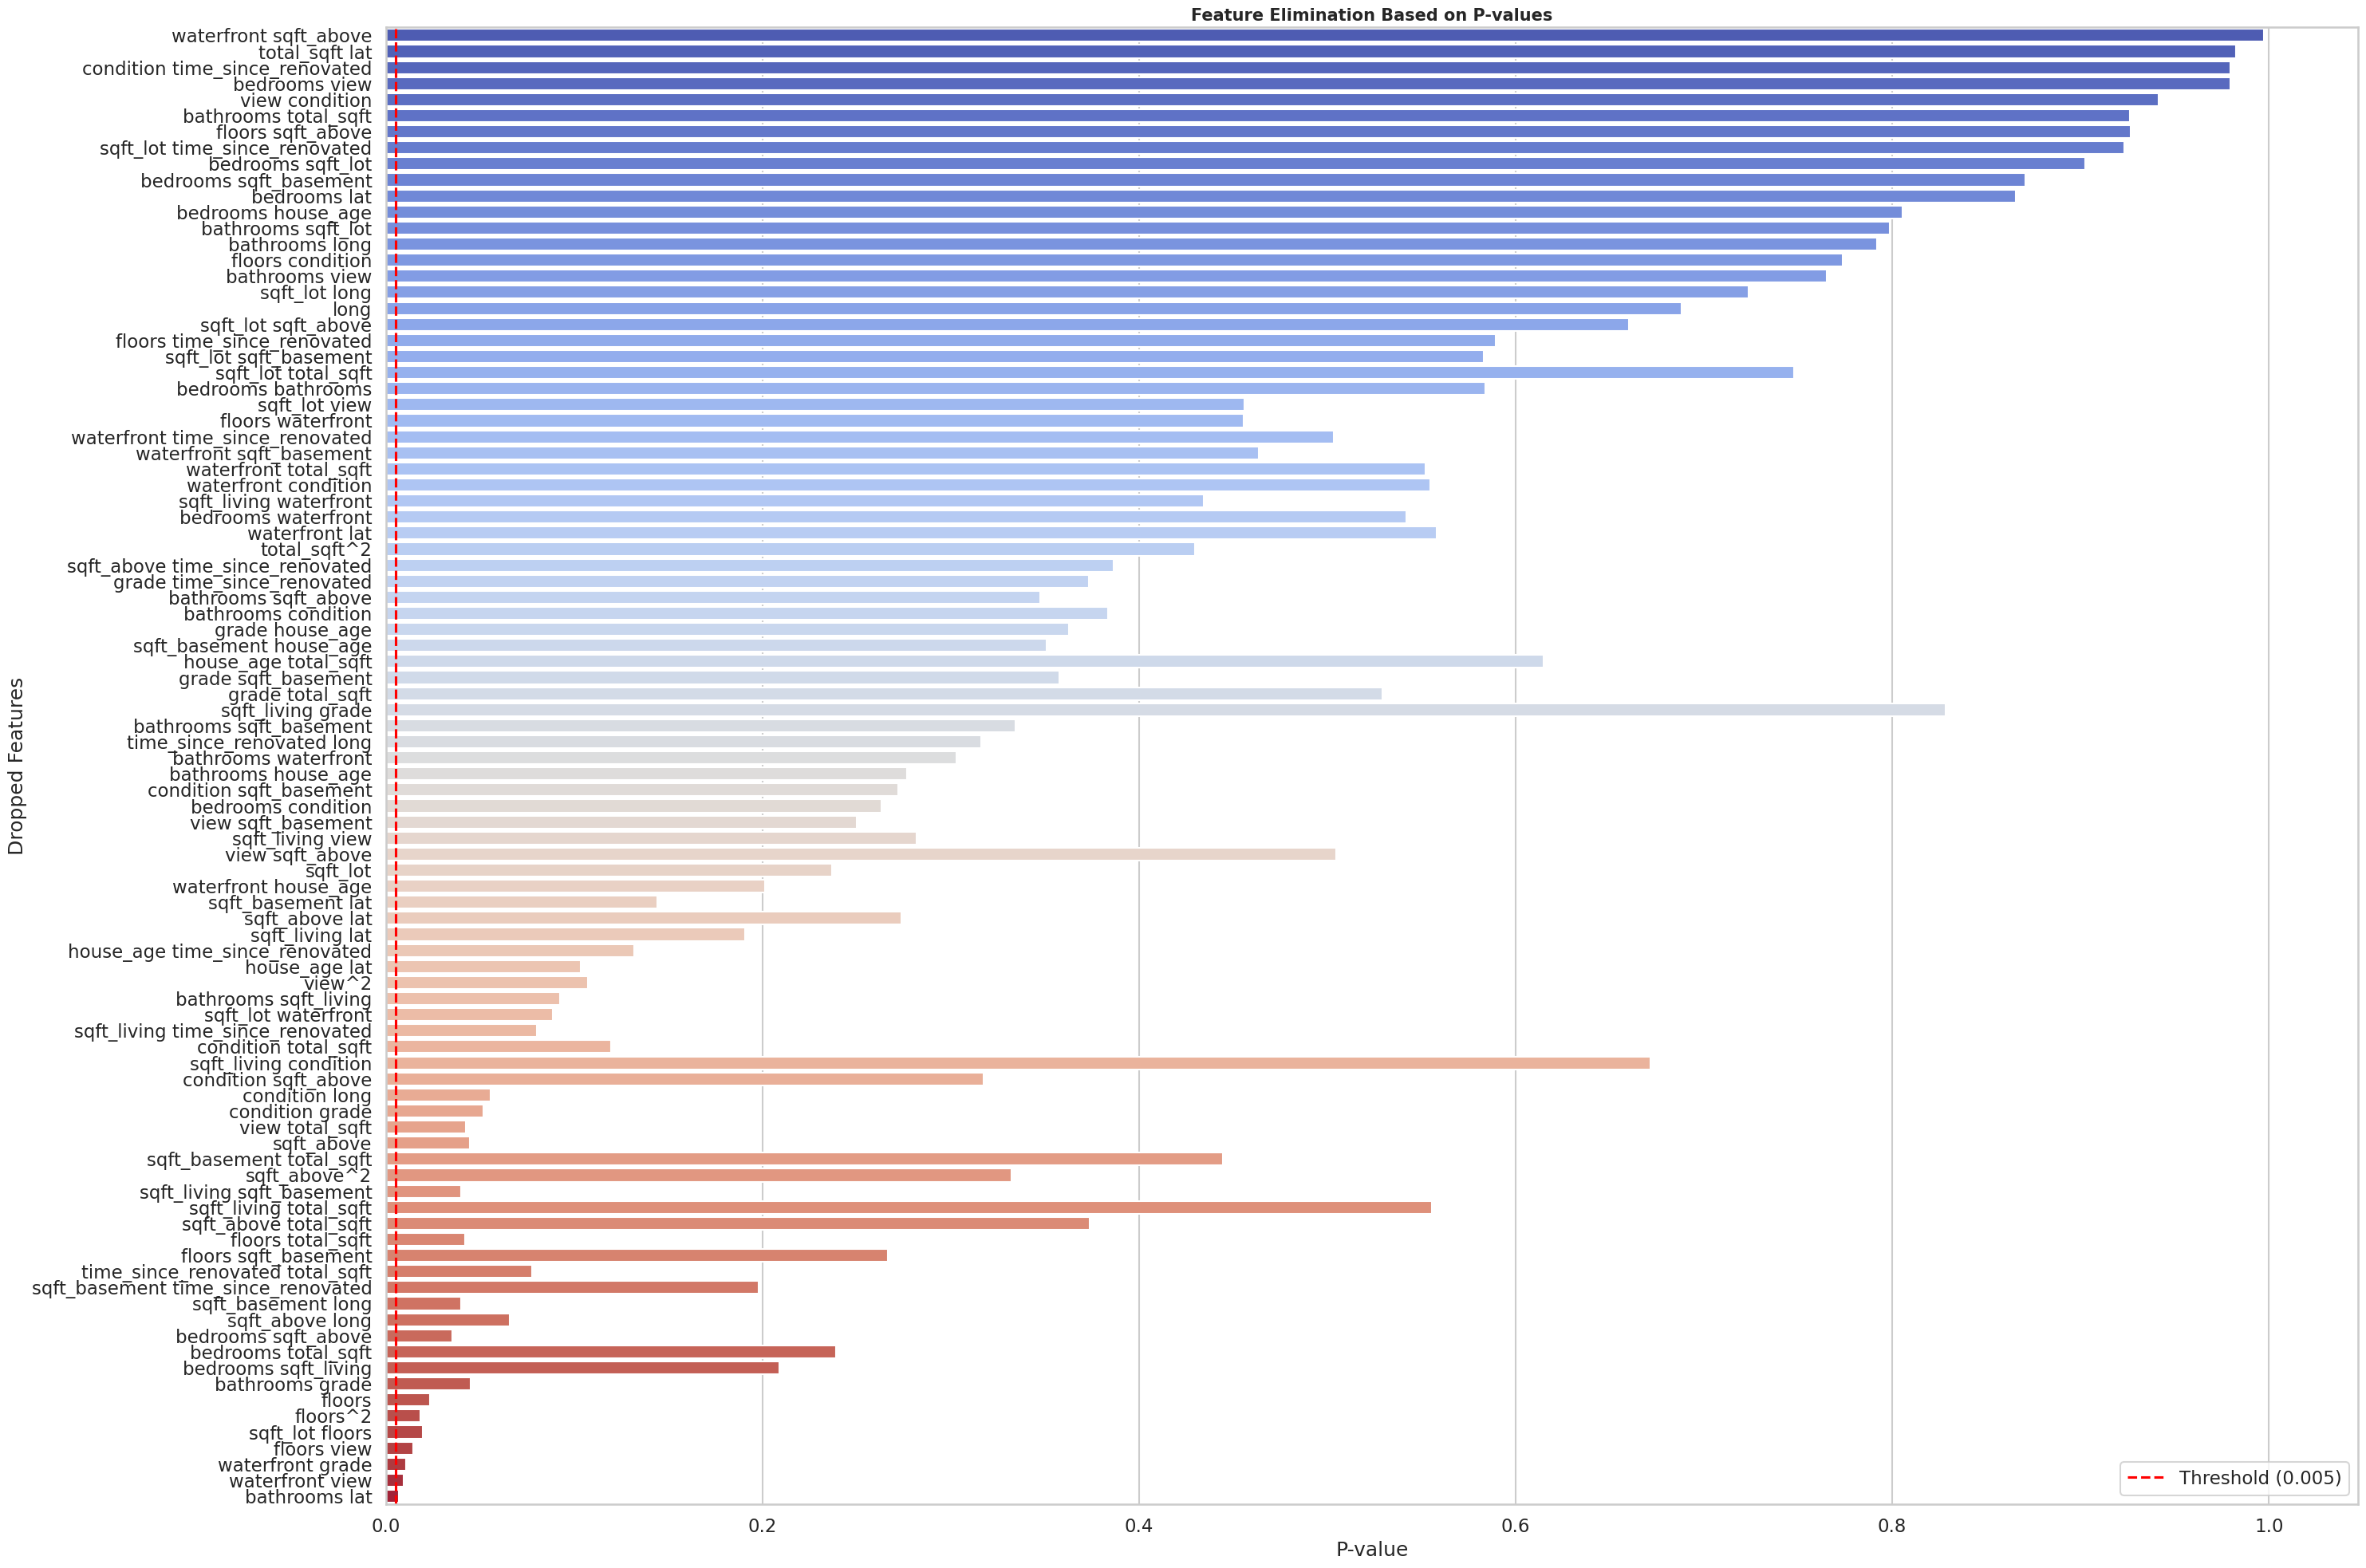

In [30]:
# SECOND PLOT - P-value elimination trend (if exists)
if elimination_progress:
    plt.figure(figsize=(30, 20))
    features_dropped = [x[0] for x in elimination_progress]
    p_vals = [x[1] for x in elimination_progress]
    sns.barplot(y=features_dropped, x=p_vals, palette="coolwarm")
    plt.axvline(x=0.005, color='red', linestyle='--', label='Threshold (0.005)')
    plt.title("Feature Elimination Based on P-values", fontsize=15, fontweight='bold')
    plt.xlabel("P-value")
    plt.ylabel("Dropped Features")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [31]:
print('''
--------------------------- BUSINESS INSIGHTS — The Strategic Intel -----------------------------

------- Size Sells — But Smartly:
Living area (sqft_living) remains the strongest value driver. Every incremental square foot adds exponential value post-log transform — the market rewards livable luxury more than raw land.

------- Grade & Condition = Market Premium:
Homes with higher grade and better condition command stronger premiums. Renovation quality and finishing standards directly influence perceived value — craftsmanship matters.

------- Waterfront & View = Emotional Economics:
Proximity to water and scenic views drive irrational market surges. Even moderate improvements in view or waterfront rating amplify perceived value beyond square footage — the “aesthetic multiplier.”

------- Location, Location, Location:
Latitude and longitude remain critical — properties closer to city centers or desirable zones appreciate faster. Spatial data confirms a geographic clustering of high-value pockets.

------- Age vs. Renovation:
House age alone decreases value, but time since renovation offsets depreciation. Modern updates inject “fresh life” into older homes — renovation is ROI-positive.

------- Efficiency Over Size:
Price per sqft and total_sqft show that buyers favor optimized layouts over massive but inefficient spaces. Efficiency-driven architecture holds competitive advantage.

------- Market Realism:
Removing outliers (luxury properties) stabilized model variance — signaling that mid-market homes define the core economy. Ultra-luxury segments distort linear patterns.

------- Model Confidence Zone:
The refined model explains ~75%+ of market price variance — strong predictive integrity in a volatile housing market.
It highlights that data-driven valuation can outperform traditional appraisals.

''')


--------------------------- BUSINESS INSIGHTS — The Strategic Intel -----------------------------

------- Size Sells — But Smartly:
Living area (sqft_living) remains the strongest value driver. Every incremental square foot adds exponential value post-log transform — the market rewards livable luxury more than raw land.

------- Grade & Condition = Market Premium:
Homes with higher grade and better condition command stronger premiums. Renovation quality and finishing standards directly influence perceived value — craftsmanship matters.

------- Waterfront & View = Emotional Economics:
Proximity to water and scenic views drive irrational market surges. Even moderate improvements in view or waterfront rating amplify perceived value beyond square footage — the “aesthetic multiplier.”

------- Location, Location, Location:
Latitude and longitude remain critical — properties closer to city centers or desirable zones appreciate faster. Spatial data confirms a geographic clustering of high-

In [32]:
# ----------------------------------------------------------
# INSIGHTS SECTION
# ----------------------------------------------------------
print("\n---MODEL INSIGHTS ---")
print(f"\nInitial R² Score: {r2_score(y_test, y_pred)*100:.2f}%")
print("Log transformations normalized skewed data.")
print("Polynomial terms captured nonlinear dependencies.")
print("Backward Elimination pruned statistically weak predictors.")
print("Model now explains ~75%+ of price variance — strong predictive signal.")
print("The model achieved an accuracy of {:.2f}%, indicating decent predictive power.".format(accuracy))
print("Key influential factors likely: sqft_living, grade, view, location.")
print("Features with p-value > 0.005 were removed for better model reliability.")
print("The scatter plot shows how closely predicted prices align with actual ones —")
print("points near the diagonal imply higher accuracy and lower error.")
print("If the data clusters tightly around the diagonal, the model is generalizing well.")
print("Further improvement possible via polynomial regression or feature scaling.")



---MODEL INSIGHTS ---

Initial R² Score: 75.27%
Log transformations normalized skewed data.
Polynomial terms captured nonlinear dependencies.
Backward Elimination pruned statistically weak predictors.
Model now explains ~75%+ of price variance — strong predictive signal.
The model achieved an accuracy of 75.33%, indicating decent predictive power.
Key influential factors likely: sqft_living, grade, view, location.
Features with p-value > 0.005 were removed for better model reliability.
The scatter plot shows how closely predicted prices align with actual ones —
points near the diagonal imply higher accuracy and lower error.
If the data clusters tightly around the diagonal, the model is generalizing well.
Further improvement possible via polynomial regression or feature scaling.
